### Support Vector Regression Model

Our [previous investigation](https://github.com/akshaysuresh1/may22-barrel/blob/main/Modeling/npk_cluster_trends.ipynb) informed us of a predominantly linear relationship between fertilizer consumption per area and rice yield across most clusters. Here, let's explore the relationship learnt by [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

In [1]:
# Load relevant packages.
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

# sklearn model
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import svr
from sklearn.metrics import mean_squared_error as mse

sns.set_style('whitegrid')

In [2]:
# Load clustered data.
df = pd.read_csv('../Final_data/rice_yield_clusters.csv')

In [3]:
# Compute fertilizer consumption per unit area.
df['N_per_area'] = df['nitrogen']/df['RICE.AREA..1000.ha.']
df['P_per_area'] = df['phosphate']/df['RICE.AREA..1000.ha.']
df['K_per_area'] = df['potash']/df['RICE.AREA..1000.ha.']

In [4]:
N_clusters = df['Cluster'].max() - df['Cluster'].min() + 1
print('No. of clusters in data = %d'% (N_clusters))

No. of clusters in data = 6


In [5]:
# Calculate no. of samples per cluster.
Nsamples = np.zeros((N_clusters))
for i in range(N_clusters):
    Nsamples[i] = len(df[df['Cluster']==i+1])
    print('We have %d data samples for cluster %d.'% (Nsamples[i], i+1))

We have 3410 data samples for cluster 1.
We have 1266 data samples for cluster 2.
We have 3077 data samples for cluster 3.
We have 624 data samples for cluster 4.
We have 1823 data samples for cluster 5.
We have 280 data samples for cluster 6.


### Hyperparameter tuning

For our random forest regressor, let us fix `n_estimators = 500` (number of trees). We will tune `max_depth` through minimization of the average 10-fold cross-validation RMSE on the training data. <br>

We have already seen that of all clusters, cluster 1 has the greatest number of samples. Also, of the three kinds of fertilizers, nitrogen consumption shows the largest variance within each cluster. Therefore, to save time, let us use the nitrogen fertilizer data from cluster 1 for tuning `max_depth`. <br>

An ideal approach would be to tune `max_depth` (and other hyperparameters) separately for each fertilizer and every cluster.

In [6]:
# Create a K-fold object.
nfold = 10
kfold = KFold(nfold, random_state = 614, shuffle=True)

# Range of max depth explored
depths = np.arange(1,9)

In [7]:
# Select cluster 1 data.
cluster1_data = df[df['Cluster']==1].copy()

# Store root mean squared error on N consumption for cluster 1.
rmse = np.zeros((nfold, len(depths)))

In [8]:
# Split into train and test data sets.
c1_train, c1_test = train_test_split(cluster1_data, test_size=0.2, shuffle=True, random_state=440)

# Loop over k-folds.
i = 0
for train_index, test_index in kfold.split(c1_train):
    # Training set
    c1_tt = c1_train.iloc[train_index]
    # Holdout set
    c1_ho = c1_train.iloc[test_index]
    
    j = 0
    for dep in depths:
        # Create model object.
        rfr = RandomForestRegressor(n_estimators=500, max_depth=dep, random_state=391)
        
        # Fit model.
        rfr.fit(c1_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), c1_tt['N_per_area'])
        
        # Predict on holdout set.
        pred_ho = rfr.predict(c1_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        
        # Compute RMSE on holdout set.
        rmse[i,j] = mse(c1_ho['N_per_area'], pred_ho, squared=False)
        j+= 1
    i+=1    

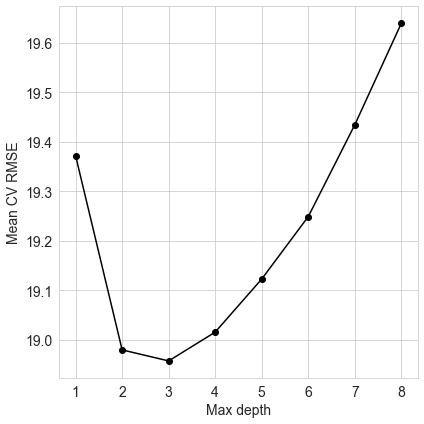

In [9]:
# Plot mean cross-validation RMSE for different depths.

fig = plt.figure(1, figsize=(6,6), tight_layout=True)
plt.plot(depths, np.mean(rmse, axis=0), '-ok')
plt.xlabel('Max depth', fontsize=14)
plt.ylabel('Mean CV RMSE', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Clearly, `max_depth = 3` returns the lowest average cross-validation RMSE on the training data. With `n_estimators = 500` and `max_depth = 3`, let's fit random forest regressors to the NPK data for each of our clusters.

Cluster 1
Size of test set = 682
Fold 1: Train/validation data size = [2455, 273]
N_RMSE = 16.1883, P_RMSE = 7.9617, K_RMSE = 4.1333

Fold 2: Train/validation data size = [2455, 273]
N_RMSE = 20.9552, P_RMSE = 8.4656, K_RMSE = 3.7047

Fold 3: Train/validation data size = [2455, 273]
N_RMSE = 19.7086, P_RMSE = 6.5776, K_RMSE = 3.8502

Fold 4: Train/validation data size = [2455, 273]
N_RMSE = 19.8101, P_RMSE = 10.4629, K_RMSE = 5.1372

Fold 5: Train/validation data size = [2455, 273]
N_RMSE = 18.5799, P_RMSE = 7.0037, K_RMSE = 3.3087

Fold 6: Train/validation data size = [2455, 273]
N_RMSE = 17.8151, P_RMSE = 6.7066, K_RMSE = 3.0791

Fold 7: Train/validation data size = [2455, 273]
N_RMSE = 22.6991, P_RMSE = 11.5756, K_RMSE = 6.0752

Fold 8: Train/validation data size = [2455, 273]
N_RMSE = 17.6206, P_RMSE = 5.9949, K_RMSE = 3.7916

Fold 9: Train/validation data size = [2456, 272]
N_RMSE = 17.7073, P_RMSE = 5.9922, K_RMSE = 3.1378

Fold 10: Train/validation data size = [2456, 272]
N_RMSE

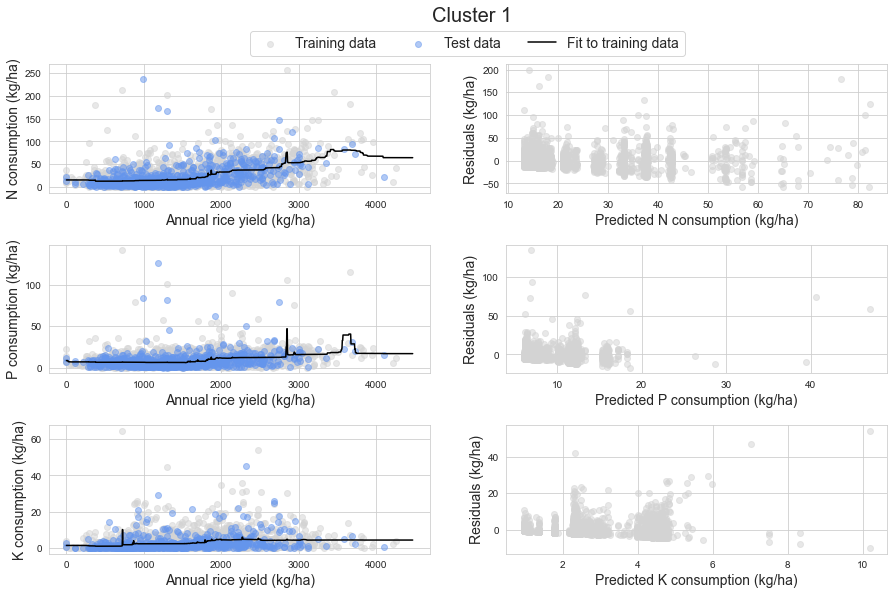

Cluster 2
Size of test set = 254
Fold 1: Train/validation data size = [910, 102]
N_RMSE = 10.4508, P_RMSE = 4.9759, K_RMSE = 6.1114

Fold 2: Train/validation data size = [910, 102]
N_RMSE = 10.4994, P_RMSE = 4.3912, K_RMSE = 4.8482

Fold 3: Train/validation data size = [911, 101]
N_RMSE = 10.0177, P_RMSE = 5.7368, K_RMSE = 7.2323

Fold 4: Train/validation data size = [911, 101]
N_RMSE = 9.9291, P_RMSE = 4.7783, K_RMSE = 6.1914

Fold 5: Train/validation data size = [911, 101]
N_RMSE = 13.4350, P_RMSE = 6.6363, K_RMSE = 9.5135

Fold 6: Train/validation data size = [911, 101]
N_RMSE = 11.4105, P_RMSE = 5.9268, K_RMSE = 6.2367

Fold 7: Train/validation data size = [911, 101]
N_RMSE = 11.8091, P_RMSE = 6.8564, K_RMSE = 7.8425

Fold 8: Train/validation data size = [911, 101]
N_RMSE = 15.8450, P_RMSE = 5.8082, K_RMSE = 7.1095

Fold 9: Train/validation data size = [911, 101]
N_RMSE = 10.4818, P_RMSE = 4.8293, K_RMSE = 6.5511

Fold 10: Train/validation data size = [911, 101]
N_RMSE = 12.7923, P

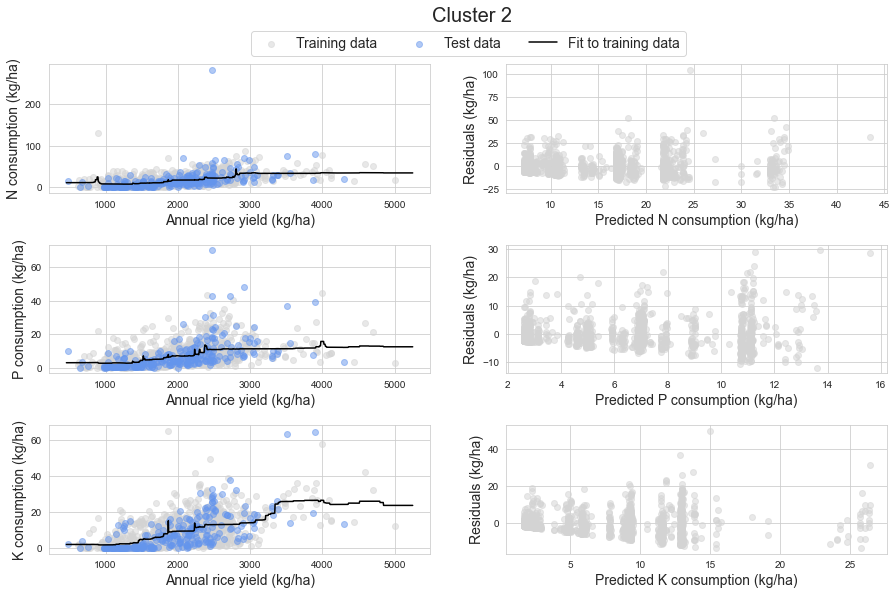

Cluster 3
Size of test set = 616
Fold 1: Train/validation data size = [2214, 247]
N_RMSE = 19.7609, P_RMSE = 6.6223, K_RMSE = 4.1431

Fold 2: Train/validation data size = [2215, 246]
N_RMSE = 20.0425, P_RMSE = 8.8033, K_RMSE = 6.4106

Fold 3: Train/validation data size = [2215, 246]
N_RMSE = 19.0017, P_RMSE = 8.3493, K_RMSE = 4.3085

Fold 4: Train/validation data size = [2215, 246]
N_RMSE = 21.6461, P_RMSE = 8.7466, K_RMSE = 5.2220

Fold 5: Train/validation data size = [2215, 246]
N_RMSE = 20.5139, P_RMSE = 8.7315, K_RMSE = 4.7817

Fold 6: Train/validation data size = [2215, 246]
N_RMSE = 22.0562, P_RMSE = 10.0138, K_RMSE = 5.7918

Fold 7: Train/validation data size = [2215, 246]
N_RMSE = 19.8875, P_RMSE = 7.7282, K_RMSE = 5.2303

Fold 8: Train/validation data size = [2215, 246]
N_RMSE = 18.9957, P_RMSE = 7.9223, K_RMSE = 5.4839

Fold 9: Train/validation data size = [2215, 246]
N_RMSE = 19.8176, P_RMSE = 7.5320, K_RMSE = 7.4253

Fold 10: Train/validation data size = [2215, 246]
N_RMSE 

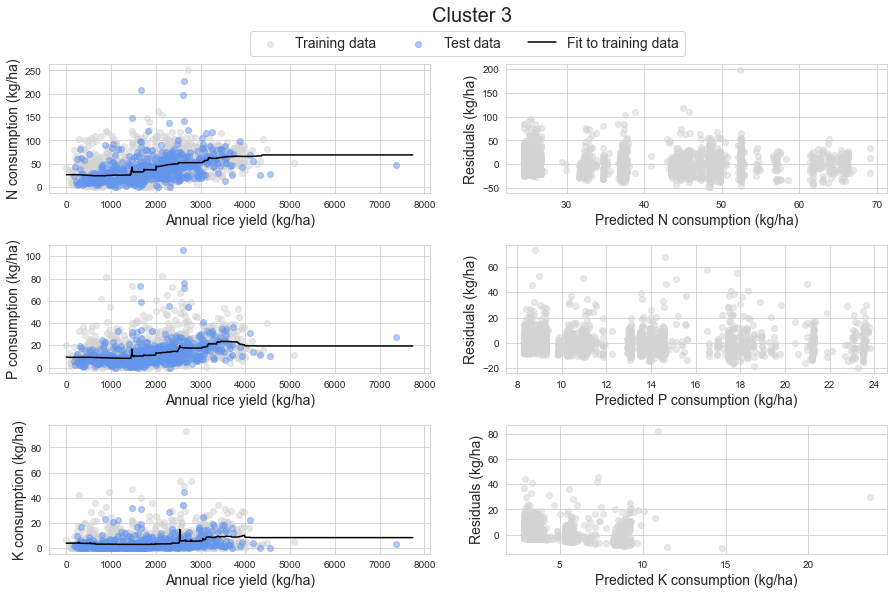

Cluster 4
Size of test set = 125
Fold 1: Train/validation data size = [449, 50]
N_RMSE = 23.0685, P_RMSE = 10.1186, K_RMSE = 14.4454

Fold 2: Train/validation data size = [449, 50]
N_RMSE = 28.9014, P_RMSE = 14.5594, K_RMSE = 16.7549

Fold 3: Train/validation data size = [449, 50]
N_RMSE = 27.1007, P_RMSE = 12.9644, K_RMSE = 15.3654

Fold 4: Train/validation data size = [449, 50]
N_RMSE = 28.8662, P_RMSE = 15.6628, K_RMSE = 15.6437

Fold 5: Train/validation data size = [449, 50]
N_RMSE = 24.1104, P_RMSE = 11.8818, K_RMSE = 19.1768

Fold 6: Train/validation data size = [449, 50]
N_RMSE = 24.6601, P_RMSE = 11.0007, K_RMSE = 12.2162

Fold 7: Train/validation data size = [449, 50]
N_RMSE = 37.7648, P_RMSE = 23.3547, K_RMSE = 10.4126

Fold 8: Train/validation data size = [449, 50]
N_RMSE = 20.8049, P_RMSE = 8.8769, K_RMSE = 9.8492

Fold 9: Train/validation data size = [449, 50]
N_RMSE = 20.8911, P_RMSE = 9.7537, K_RMSE = 10.3818

Fold 10: Train/validation data size = [450, 49]
N_RMSE = 39.9

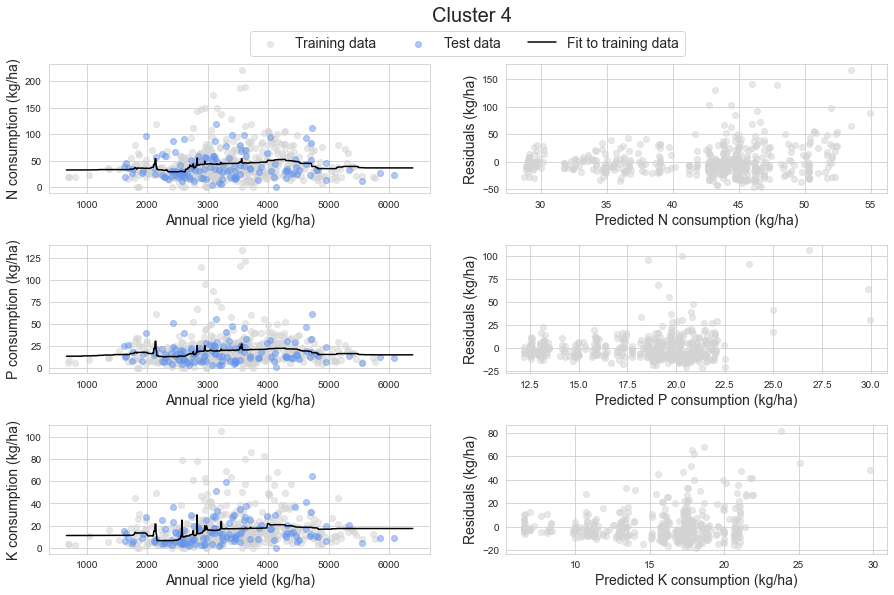

Cluster 5
Size of test set = 365
Fold 1: Train/validation data size = [1312, 146]
N_RMSE = 23.7199, P_RMSE = 7.5067, K_RMSE = 3.2167

Fold 2: Train/validation data size = [1312, 146]
N_RMSE = 22.2661, P_RMSE = 8.0686, K_RMSE = 3.6233

Fold 3: Train/validation data size = [1312, 146]
N_RMSE = 19.1927, P_RMSE = 7.9729, K_RMSE = 2.8883

Fold 4: Train/validation data size = [1312, 146]
N_RMSE = 20.1146, P_RMSE = 7.0342, K_RMSE = 3.8249

Fold 5: Train/validation data size = [1312, 146]
N_RMSE = 19.5861, P_RMSE = 6.4685, K_RMSE = 3.2241

Fold 6: Train/validation data size = [1312, 146]
N_RMSE = 17.6996, P_RMSE = 6.1567, K_RMSE = 3.0095

Fold 7: Train/validation data size = [1312, 146]
N_RMSE = 21.7536, P_RMSE = 8.3602, K_RMSE = 3.5445

Fold 8: Train/validation data size = [1312, 146]
N_RMSE = 20.3749, P_RMSE = 8.3360, K_RMSE = 3.4637

Fold 9: Train/validation data size = [1313, 145]
N_RMSE = 22.6208, P_RMSE = 6.4944, K_RMSE = 2.3696

Fold 10: Train/validation data size = [1313, 145]
N_RMSE =

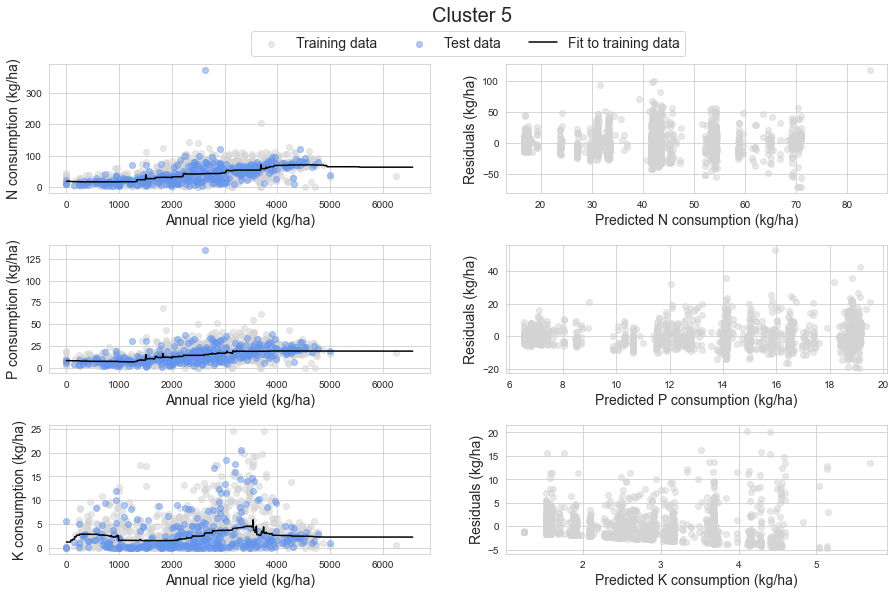

Cluster 6
Size of test set = 56
Fold 1: Train/validation data size = [201, 23]
N_RMSE = 19.8208, P_RMSE = 11.6571, K_RMSE = 11.9290

Fold 2: Train/validation data size = [201, 23]
N_RMSE = 19.2726, P_RMSE = 7.8293, K_RMSE = 11.2237

Fold 3: Train/validation data size = [201, 23]
N_RMSE = 15.0706, P_RMSE = 5.7706, K_RMSE = 6.3127

Fold 4: Train/validation data size = [201, 23]
N_RMSE = 16.5061, P_RMSE = 5.2991, K_RMSE = 5.5433

Fold 5: Train/validation data size = [202, 22]
N_RMSE = 18.1906, P_RMSE = 7.9933, K_RMSE = 7.4790

Fold 6: Train/validation data size = [202, 22]
N_RMSE = 16.3469, P_RMSE = 6.4069, K_RMSE = 7.0185

Fold 7: Train/validation data size = [202, 22]
N_RMSE = 12.8294, P_RMSE = 5.8630, K_RMSE = 9.3245

Fold 8: Train/validation data size = [202, 22]
N_RMSE = 19.9217, P_RMSE = 7.9442, K_RMSE = 7.7788

Fold 9: Train/validation data size = [202, 22]
N_RMSE = 20.4431, P_RMSE = 11.4195, K_RMSE = 4.8110

Fold 10: Train/validation data size = [202, 22]
N_RMSE = 15.9468, P_RMSE 

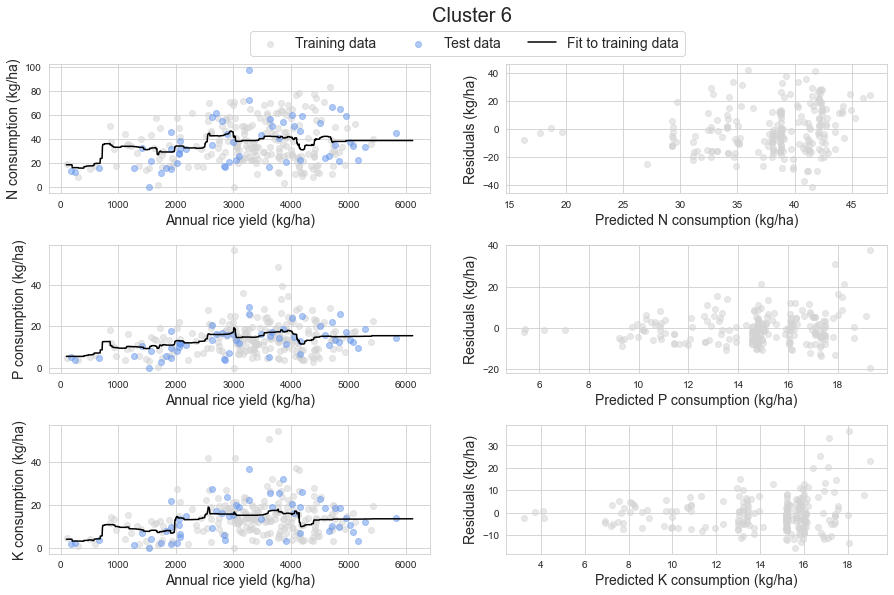

In [10]:
# Store mean-squared errors on test NPK data for each cluster.
N_rmse_test = np.zeros(N_clusters)
P_rmse_test = np.zeros(N_clusters)
K_rmse_test = np.zeros(N_clusters)

# Loop over clusters.
for i in range(N_clusters):
    start_time = time.time()
    selection = df[df['Cluster']==i+1]
    
    # Train-test split
    df_train, df_test = train_test_split(selection.copy(), test_size=0.2, shuffle=True, random_state=440)
    print('Cluster %d'% (i+1))
    print('Size of test set = %d'% (len(df_test)))
    
    # Create model objects, one each for N, P, and K.
    rfr_N = RandomForestRegressor(n_estimators=500, max_depth=3, random_state=391)
    rfr_P = RandomForestRegressor(n_estimators=500, max_depth=3, random_state=391)
    rfr_K = RandomForestRegressor(n_estimators=500, max_depth=3, random_state=391)
    
    j = 0 # k-fold index
    # Loop through k-fold.
    for train_index, test_index in kfold.split(df_train):
        # Training set
        df_tt = df_train.iloc[train_index]
        # Holdout set
        df_ho = df_train.iloc[test_index]
        print('Fold %d: Train/validation data size = [%d, %d]'% (j+1, len(df_tt), len(df_ho)))

        # Fit models to NPK data.
        rfr_N.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['N_per_area'])
        rfr_P.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['P_per_area'])
        rfr_K.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['K_per_area'])        
        
        # Obtain predictions on the holdout set.
        pred_N = rfr_N.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        pred_P = rfr_P.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        pred_K = rfr_K.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        
        # Compute root mean squared error (RMSE) on the holdout set.
        rmse_fold_N = mse(df_ho['N_per_area'], pred_N, squared=False)
        rmse_fold_P = mse(df_ho['P_per_area'], pred_P, squared=False)
        rmse_fold_K = mse(df_ho['K_per_area'], pred_K, squared=False)
        print('N_RMSE = %.4f, P_RMSE = %.4f, K_RMSE = %.4f\n'% (rmse_fold_N, rmse_fold_P, rmse_fold_K))
        j+=1
  
    # Predict on test data.
    test_pred_N = rfr_N.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    test_pred_P = rfr_P.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    test_pred_K = rfr_K.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    
    # Record RMSE on test data.
    N_rmse_test[i] = mse(df_test['N_per_area'], test_pred_N, squared=False)
    P_rmse_test[i] = mse(df_test['P_per_area'], test_pred_P, squared=False)    
    K_rmse_test[i] = mse(df_test['K_per_area'], test_pred_K, squared=False)    
    print('RMSE on N test data = %.4f'% (N_rmse_test[i]))
    print('RMSE on P test data = %.4f'% (P_rmse_test[i]))
    print('RMSE on K test data = %.4f'% (K_rmse_test[i]))
    
    # Asssess time taken for model fitting.
    end_time = time.time()
    model_fit_time = (end_time - start_time)/60.0
    print('RandomForestRegressor model fitting took %.2f minutes.'% (model_fit_time))
    
    # Line fit for plotting
    x = np.linspace(0.95*selection['RICE.YIELD..kg.per.ha.'].min(),
                    1.05*selection['RICE.YIELD..kg.per.ha.'].max(), 1000)
    y_N = rfr_N.predict(x.reshape(-1,1))
    y_P = rfr_P.predict(x.reshape(-1,1))
    y_K = rfr_K.predict(x.reshape(-1,1))
    
    # Compute prediction on training data.
    train_pred_N = rfr_N.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    train_pred_P = rfr_P.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    train_pred_K = rfr_K.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    
    # Compute residual on training data.
    train_residual_N = df_train['N_per_area'] - train_pred_N
    train_residual_P = df_train['P_per_area'] - train_pred_P
    train_residual_K = df_train['K_per_area'] - train_pred_K    
    
    # Plotting
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
    # Row 0, column 0: Nitrogen consumption (kg/ha) vs. rice yield (kg/ha)
    l1 = axes[0,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['N_per_area'], c='lightgray', alpha=0.5,
                     label='Training data')
    l2 = axes[0,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['N_per_area'], c='cornflowerblue', alpha=0.5,
                     label='Test data') 
    l3, = axes[0,0].plot(x, y_N, '-k', label='Fit')
    axes[0,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[0,0].set_ylabel('N consumption (kg/ha)', fontsize=14)
    # Row 0, column 1: Residual on training data vs. predicted N consumption
    axes[0,1].scatter(x=train_pred_N, y=train_residual_N, c='lightgray', alpha=0.5)
    axes[0,1].set_xlabel('Predicted N consumption (kg/ha)', fontsize=14)
    axes[0,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Row 1, column 0: Phosphate consumption (kg/ha) vs. rice yield (kg/ha)
    axes[1,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['P_per_area'], c='lightgray', alpha=0.5)
    axes[1,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['P_per_area'], c='cornflowerblue', alpha=0.5) 
    axes[1,0].plot(x, y_P, '-k')
    axes[1,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[1,0].set_ylabel('P consumption (kg/ha)', fontsize=14)
    # Row 1, column 1: Residual on training data vs. predicted P consumption
    axes[1,1].scatter(x=train_pred_P, y=train_residual_P, c='lightgray', alpha=0.5)
    axes[1,1].set_xlabel('Predicted P consumption (kg/ha)', fontsize=14)
    axes[1,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Row 2, column 0: Potash consumption (kg/ha) vs. rice yield (kg/ha)
    axes[2,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['K_per_area'], c='lightgray', alpha=0.5)
    axes[2,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['K_per_area'], c='cornflowerblue', alpha=0.5) 
    axes[2,0].plot(x, y_K, '-k')
    axes[2,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[2,0].set_ylabel('K consumption (kg/ha)', fontsize=14)
    # Row 2, column 1: Residual on training data vs. predicted K consumption
    axes[2,1].scatter(x=train_pred_K, y=train_residual_K, c='lightgray', alpha=0.5)
    axes[2,1].set_xlabel('Predicted K consumption (kg/ha)', fontsize=14)
    axes[2,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Figure settings
    fig.subplots_adjust(left=0.01, right=0.98, top=0.90, bottom=0.05, hspace=0.4)
    # Figure legend
    fig.legend((l1,l2,l3), ('Training data','Test data','Fit to training data'), loc=(0.28, 0.905),
               ncol=3, fontsize=14)
    # Figure title
    fig.suptitle('Cluster %d' % (i+1), y=1.0, fontsize=20)
    plt.show()


Though a random forest regressor allows for non-linearities in the data, it is a "greedy" algorithm. In other words, it tends to overfit the data as seen in the above graphs. One can possibly mitigate against overfitting by increasing either the minimum number of samples per leaf (set to 1 by default) or the number of estimators. Note that we arbitrarily chose `n_estimators = 500` in our analysis. Ideally, we would need to tune `n_estimators` via cross-validation too.